Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
!python -m textblob.download_corpora
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


##Data Imports


I'll be working with two individual datasets, first the GoEmotion Dataset which contains the following format:

GoEmotion:
----------

  **text**: The text of the comment (with masked tokens, as described in the paper)

  **id**: The unique id of the comment.
  
  **author**: The Reddit username of the comment's author.
  
  **subreddit**: The subreddit that the comment belongs to.
  
  **link_id**: The link id of the comment.
  
  **parent_id**: The parent id of the comment.
  
  **created_utc**: The timestamp of the comment.
  
  **rater_id**: The unique id of the annotator.
  
  **example_very_unclear**: Whether the annotator marked the example as being very unclear or difficult to label (in this case they did not choose any emotion labels).
  
  **separate columns representing each of the emotion categories, with binary labels (0 or 1)**


Hugging Face - DairAI:
-----------

  **text**: a string feature.

  **label**: a classification label, with possible values including sadness (0),joy (1), love (2), anger (3), fear (4), surprise (5).


GoEmotion - Reddit Data Import:

In [3]:
#The GoEmotion dataset import:

!mkdir -p data/full_dataset
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df_GoEmotion_raw_data = pd.concat([
    pd.read_csv("data/full_dataset/goemotions_1.csv"),
    pd.read_csv("data/full_dataset/goemotions_2.csv"),
    pd.read_csv("data/full_dataset/goemotions_3.csv")
], ignore_index=True)

print(df_GoEmotion_raw_data.shape)
df_GoEmotion_raw_data.head()

--2025-10-29 19:23:51--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.09s   

2025-10-29 19:23:51 (150 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-10-29 19:23:51--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting re

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_GoEmotion_unique = df_GoEmotion_raw_data.drop_duplicates(subset=["id"])  #Keep first occurrence for each text
print(df_GoEmotion_unique.shape)
print(df_GoEmotion_raw_data.shape)

(58011, 37)
(211225, 37)


In [5]:
matches = df_GoEmotion_raw_data[df_GoEmotion_raw_data["author"].astype(str).str.contains("TheGreen888")]
print(matches["rater_id"])

1         37
78116     61
90121      7
160913    36
175893    27
Name: rater_id, dtype: int64


After an inspection within the data, I realized that the combination of the first 3 csv files contained texts containing the vote of each rater. Since most of these texts had more than 1 raters, labeling the text, the number of examples drastically increased from 58011 text examples to 211225 text example ratings. I've decided upon keeping every rater's vote in order to be able to help my model better generalize within the future. If my model were to only learn from a single rater, it'd lose it's potential to generalize better. Even if some of the ratings are far from the most raters for a specific text, it'd be a good idea for my model to see that side of that text, and be prepared for it.

In [6]:
df_GoEmotion = df_GoEmotion_raw_data[df_GoEmotion_raw_data["example_very_unclear"] != True]

Since I didn't want to train my model with unclear data, I've decided upon clearing the examples which contained the True value for the "example_very_unclear" feature. That way, I will be able to train my model with a clearer data within the future



After taking a clear look at the shape of the newly cleaned df_GoEmotion dataset, we can clearly see that 3.5k~ number of examples were labeled as unclear

In [7]:
print(df_GoEmotion.shape)
df_GoEmotion.isnull().sum()

(207814, 37)


,0
text,0
id,0
author,0
subreddit,0
link_id,0
parent_id,0
created_utc,0
rater_id,0
example_very_unclear,0
admiration,0


Hugging Face - Twitter Data Import

In [8]:
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df_dairAi_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_dairAI_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])
df_dairAI_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])

print(df_dairAi_train.shape)
print(df_dairAi_train.head)

(16000, 2)
<bound method NDFrame.head of                                                     text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]>


In [9]:
df_dairAi_train.isnull().sum()

,0
text,0
label,0


Preprocessing the data
----------------------

In [10]:
datasets = [df_GoEmotion, df_dairAi_train, df_dairAI_test, df_dairAI_validation]

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')
    return ReviewText

for temp_df in datasets:
  temp_df['text'] = preprocess(temp_df['text'])

Changing the format of dairAi into GoEmotion's format

In [11]:
goemotions_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

dairai_labels = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def multiLabelFormat(df):
  for emotion in goemotions_labels:
    df[emotion] = 0

  for i, row in df.iterrows():
    label = row["label"]
    emo = dairai_labels[label]
    df.at[i, emo] = 1

for x in datasets[1:3]:
    multiLabelFormat(x)

df_dairAI_test.head()

,text,label,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,im feeling rather rotten so im not very ambiti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,im updating my blog because i feel shitty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,i never make her separate from me because i do...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,i left with my bouquet of red and yellow tulip...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,i was feeling a little vain when i did this one,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
#PWR stands for Polarity, Word_Count and review_Len
def PWR(df):
    df['Polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['review_len'] = df['text'].apply(lambda x: len(str(x)))

for i in datasets:
    PWR(i)

df_dairAI_test.head()

,text,label,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,pride,realization,relief,remorse,sadness,surprise,neutral,Polarity,word_count,review_len
0,im feeling rather rotten so im not very ambiti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.09478,11,59
1,im updating my blog because i feel shitty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00000,8,41
2,i never make her separate from me because i do...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00000,22,97
3,i left with my bouquet of red and yellow tulip...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.12500,21,113
4,i was feeling a little vain when i did this one,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,-0.18750,11,47


Out of curiosity, while reading through and examining the examples, I've realized that a sentence such as "im updating my blog because i feel shitty" is considered neutral (Polarity = 0) within my data. At first, I was greatly suprised by this. But after great research, I've realised that some words such as "shitty" was not within textblog's dictionary, which caused some problems during polarity calculations. I plan on using better polarity calculator models within the future if i can

In [13]:
print("Unexpected polarity Scores:")
print("'I love my job, yet I hate it's workplace.': ", TextBlob("I love my job, yet I hate it's workplace.").polarity)
print("'I love my job, yet I hate it's workplace. shitty': ", TextBlob("I love my job, yet I hate it's workplace. shitty").polarity)
print("'shit': ", TextBlob("shit").polarity)
print("'shitty': ", TextBlob("shitty").polarity)

print("\nWe can see how some of the words are undefined within the TextBlob's dictionaty. Ergo, causing issues during its' polarity score calculationşs.")

Unexpected polarity Scores:
'I love my job, yet I hate it's workplace.':  -0.15000000000000002
'I love my job, yet I hate it's workplace. shitty':  -0.15000000000000002
'shit':  -0.2
'shitty':  0.0

We can see how some of the words are undefined within the TextBlob's dictionaty. Ergo, causing issues during its' polarity score calculationşs.


Positive, Neutral and Negative Polarity Reviews
--------------------------

In [14]:
def polarityEquals(value, df):
    cl = df.loc[df.Polarity == value, ['text']].sample(5).values
    for c in cl:
        print(c[0])

def polarityLessOrEquals(value, df):
    cl = df.loc[df.Polarity <= value, ['text']].sample(5).values
    for c in cl:
        print(c[0])

In [15]:
print("GoEmotion - Reddit:")
print("================================================== Polarity = 1 ==================================================")
polarityEquals(1,datasets[0])

print("================================================== Polarity = 0 ==================================================")
polarityEquals(0,datasets[0])

print("================================================== Polarity = -1 ==================================================")
polarityEquals(-1,datasets[0])

print("================================================== Polarity <= 0.7 =================================================")
polarityLessOrEquals(0.7,datasets[0])

print("================================================== Polarity <= -0.7 ================================================")
polarityLessOrEquals(-0.7,datasets[0])

print("\n\nDair-Ai - Twitter:")
print("================================================== Polarity = 1 ==================================================")
polarityEquals(1,datasets[1])

print("================================================== Polarity = 0 ==================================================")
polarityEquals(0,datasets[1])

print("================================================== Polarity = -1 ==================================================")
polarityEquals(-1,datasets[1])

print("================================================== Polarity <= 0.7 =================================================")
polarityLessOrEquals(0.7,datasets[1])

print("================================================== Polarity <= -0.7 ================================================")
polarityLessOrEquals(-0.7,datasets[1])

GoEmotion - Reddit:
================================================== Polarity = 1 ==================================================
Delightfully devilish, [NAME]. 
One of the best photos I’ve seen of the Arch. Breathtaking.
Very good points. Thank you for sharing that!
Wauw! Those weapons are awesome!!
I see that the facebook and twitter crowd is leaking into our sub. Awesome.
================================================== Polarity = 0 ==================================================
I'll have to think about that one but maybe if you're down😂
OMG I’m dying she said carrot!!!!
omg, id cry if this was my store 
So, where we at on this? 
This sentence has a very different meaning in Australia.
================================================== Polarity = -1 ==================================================
I thought it was but didn't find anything in Reddit's horrible search. Thank you and I apologize for this.
One wonders just how awful [NAME] and [NAME] have to be before peopl

Distribution of review sentiment polarity score
----------------

In [16]:
def Distribution(df, features, titles, colors):
    for feature, title, color in zip(features, titles, colors):
        sns.distplot(x=df[feature], bins=50, color=color)
        plt.title(title, size=15)
        plt.xlabel(feature)
        plt.show()

Distributions of GoEmotion - Reddit:

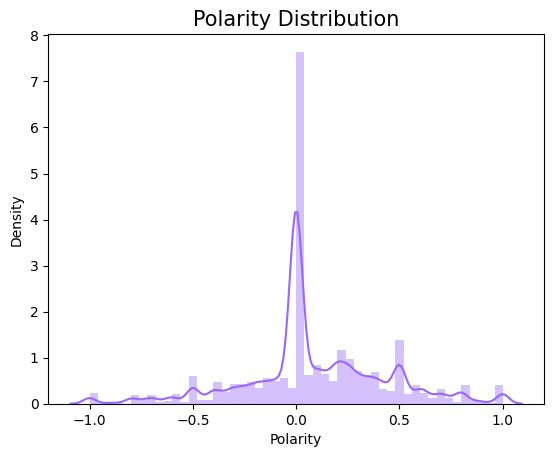

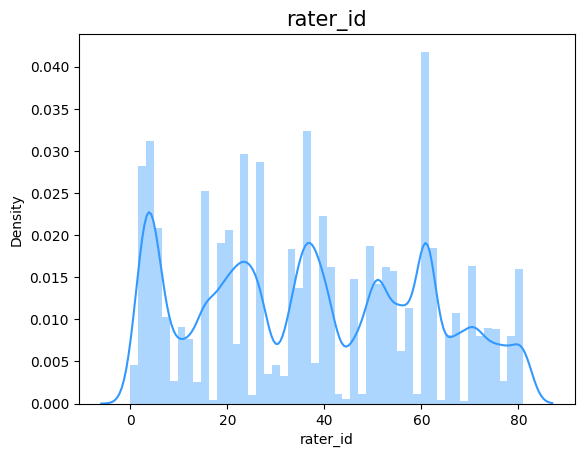

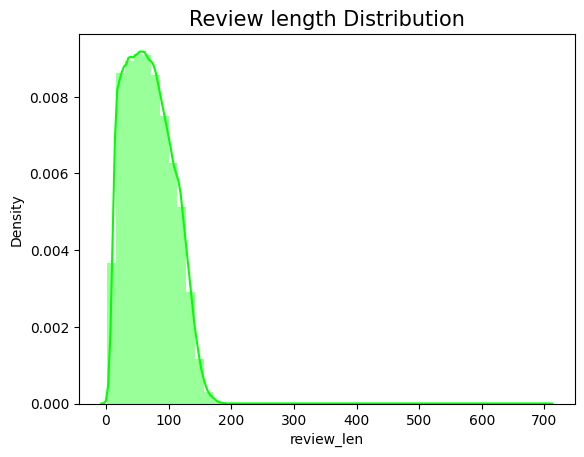

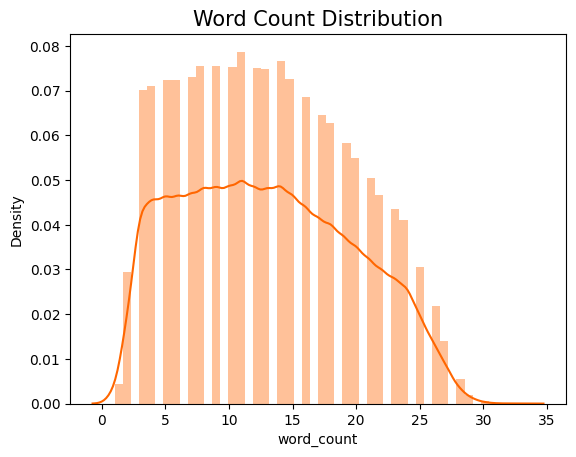

In [17]:
features = ['Polarity', 'rater_id', 'review_len', 'word_count']
titles = ['Polarity Distribution', 'rater_id', 'Review length Distribution', 'Word Count Distribution']
colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']


Distribution(df_GoEmotion, features, titles, colors)

Distributions of dairAi:

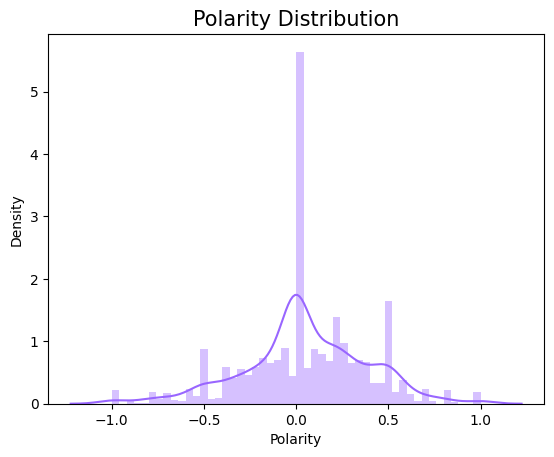

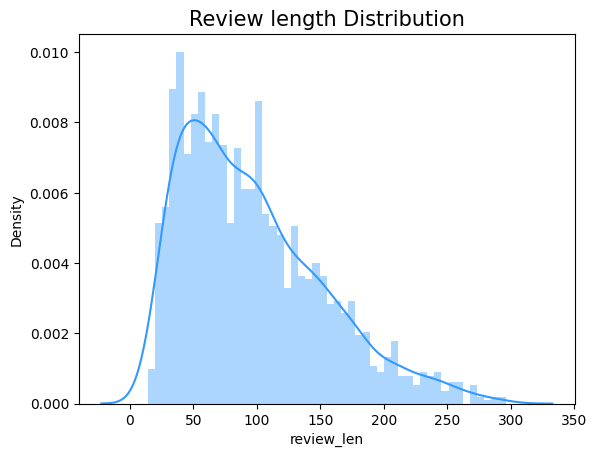

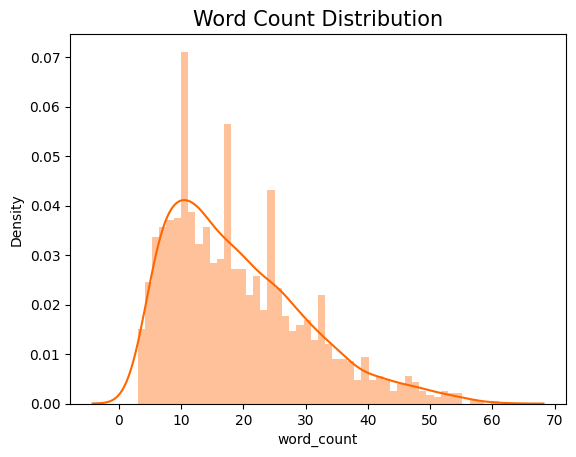

In [18]:
features = ['Polarity', 'review_len', 'word_count']
titles = ['Polarity Distribution', 'Review length Distribution', 'Word Count Distribution']
colors = ['#9966ff', '#3399ff', '#ff6600']

Distribution(df_dairAI_test, features, titles, colors)

## Distribution of Emotional Labels


In [19]:
def labelDistribution(df, title):
    emotion_counts = df[goemotions_labels].sum().sort_values(ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(x=emotion_counts.values, y=emotion_counts.index, palette="viridis")
    plt.title(title, size=15)
    plt.xlabel("Count")
    plt.ylabel("Emotion")
    plt.show()

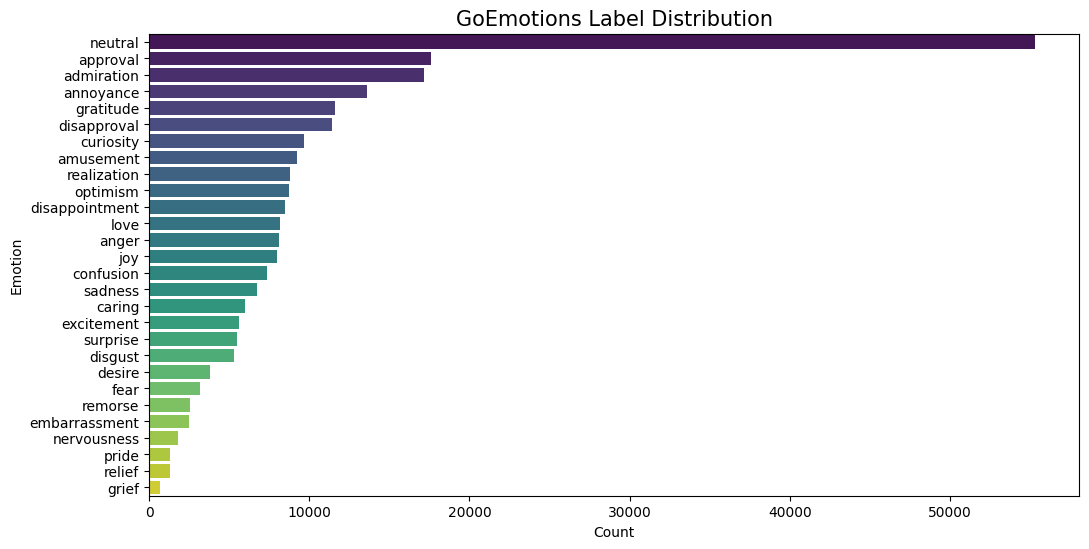

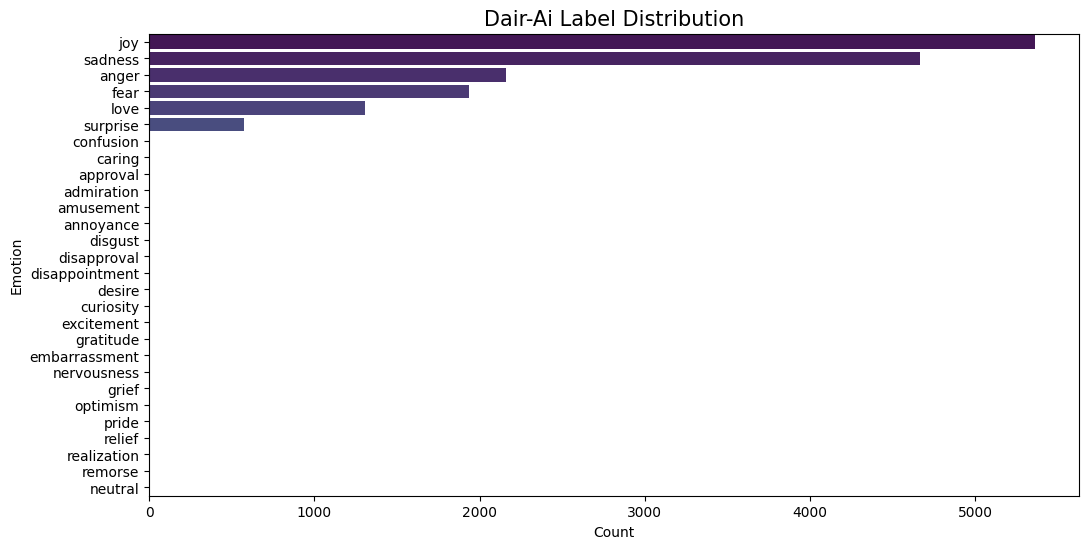

In [20]:
labelDistribution(df_GoEmotion, "GoEmotions Label Distribution")
labelDistribution(df_dairAi_train, "Dair-Ai Label Distribution")

Countplot of the Neutral Label - A greater look into the Neutral Label

In [47]:
def countPlotNeutral(df):
    sns.countplot(x = 'joy', palette='viridis', data=df)
    plt.title('Joy Distribution', size=15)
    plt.xlabel('joy')
    plt.show()

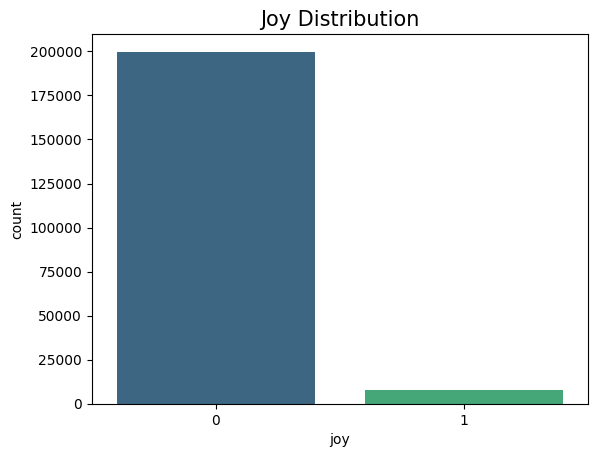

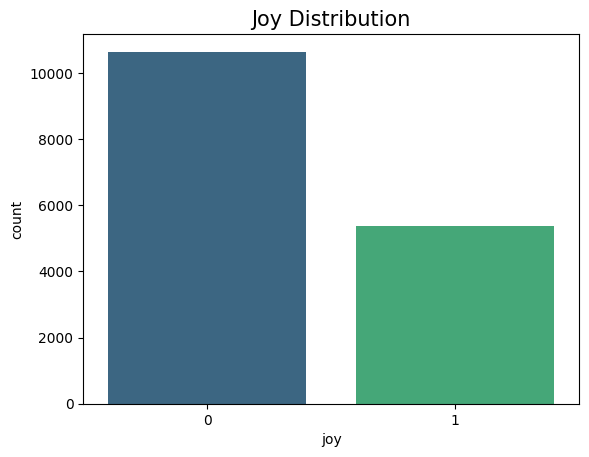

In [48]:
countPlotNeutral(df_GoEmotion)
countPlotNeutral(df_dairAi_train)

## Unigrams, Bigrams and Trigrams

In [23]:
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)

    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df

In [24]:
def stopWordsNone(df):
    stop_words = None
    n = 20
    unigrams = get_top_ngrams(df['text'], (1, 1), stop_words, n)
    bigrams = get_top_ngrams(df['text'], (2, 2), stop_words, n)
    trigrams = get_top_ngrams(df['text'], (3, 3), stop_words, n)

    return unigrams, bigrams, trigrams

def stopWordsEnglish(df):
  stop_words = 'english'
  n = 20
  unigrams_st = get_top_ngrams(df['text'], (1, 1), stop_words, n)
  bigrams_st = get_top_ngrams(df['text'], (2, 2), stop_words, n)
  trigrams_st = get_top_ngrams(df['text'], (3, 3), stop_words, n)

  return unigrams_st, bigrams_st, trigrams_st

In [25]:
uni_goEmotion, bi_goEmotion, tri_goEmotion = stopWordsNone(df_GoEmotion)
uni_st_goEmotion, bi_st_goEmotion, tri_st_goEmotion = stopWordsEnglish(df_GoEmotion)

uni_dairAI, bi_dairAI, tri_dairAI = stopWordsNone(df_dairAI_test)
uni_st_dairAI, bi_st_dairAI, tri_st_dairAI = stopWordsEnglish(df_dairAI_test)

## Unigrams Distribution

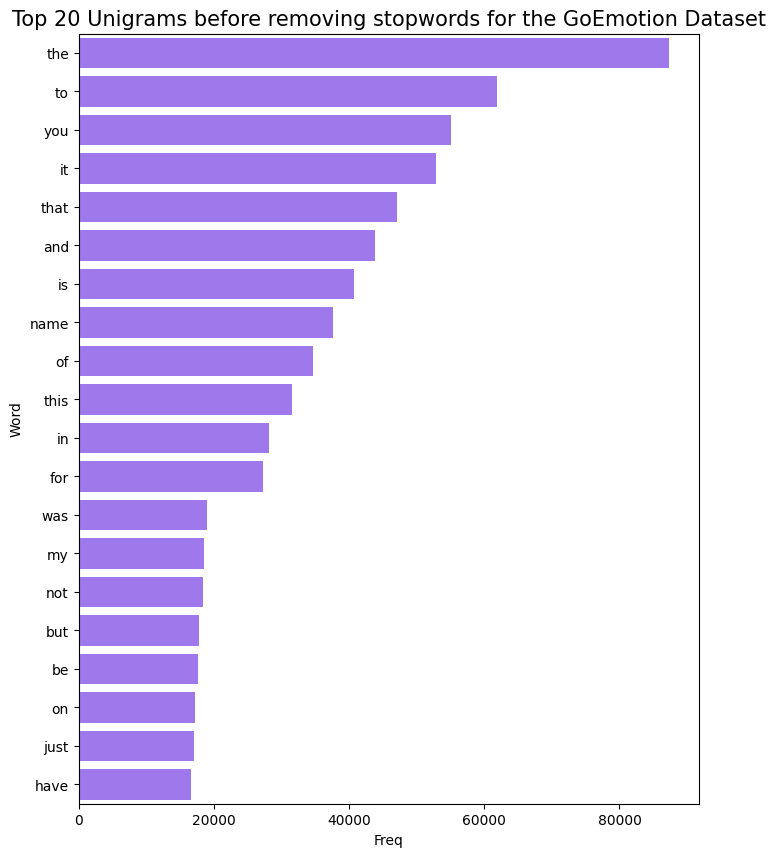

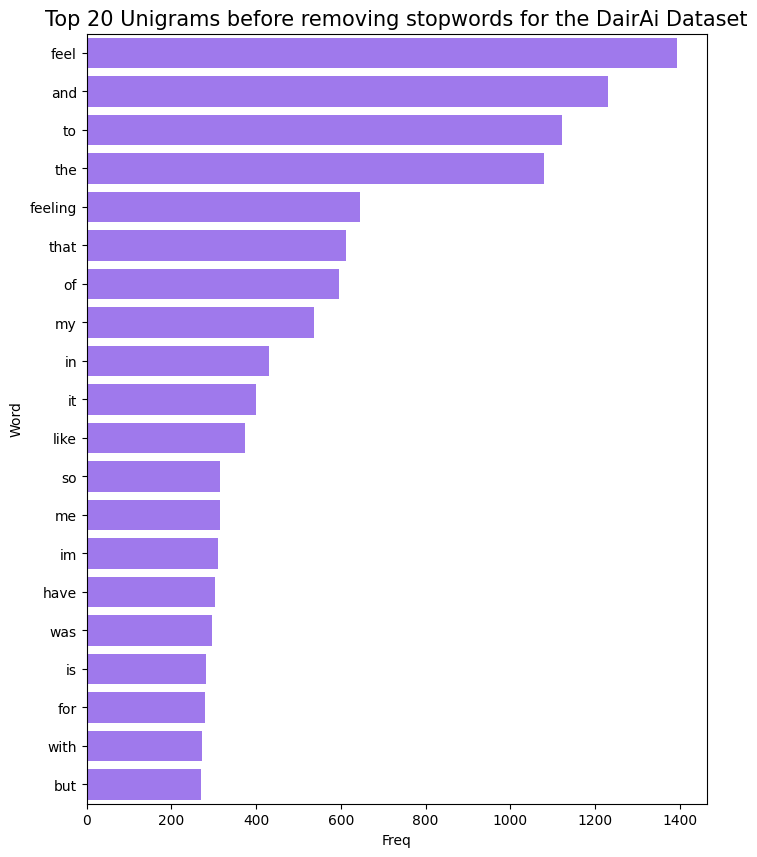

In [26]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[0], data=uni_goEmotion)
plt.title('Top 20 Unigrams before removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[0], data=uni_dairAI)
plt.title('Top 20 Unigrams before removing stopwords for the DairAi Dataset', size=15)
plt.show()

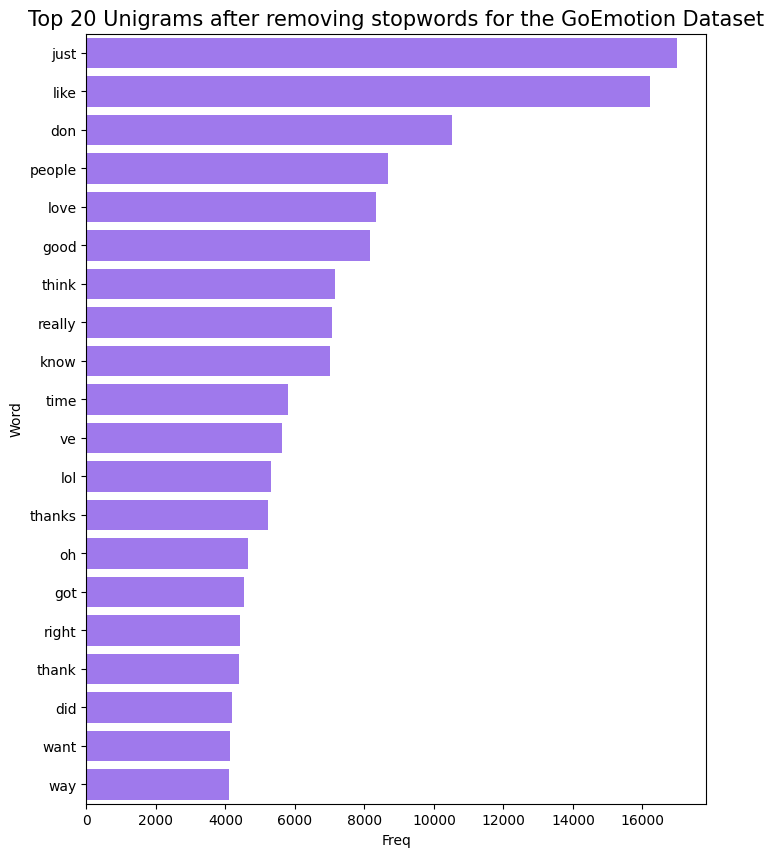

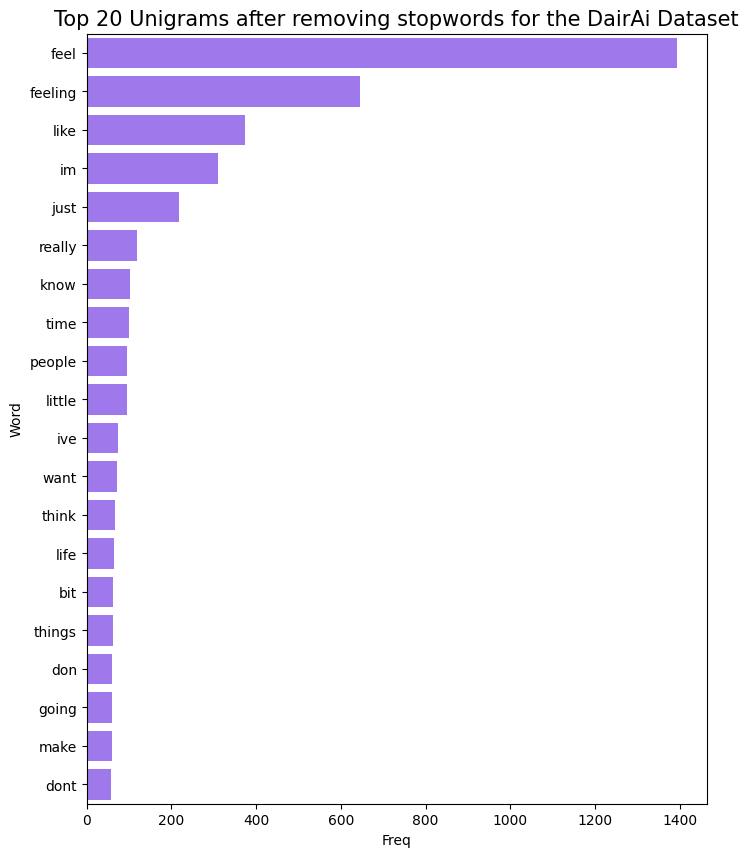

In [27]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[0], data=uni_st_goEmotion)
plt.title('Top 20 Unigrams after removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[0], data=uni_st_dairAI)
plt.title('Top 20 Unigrams after removing stopwords for the DairAi Dataset', size=15)
plt.show()

## Bigrams Distribution

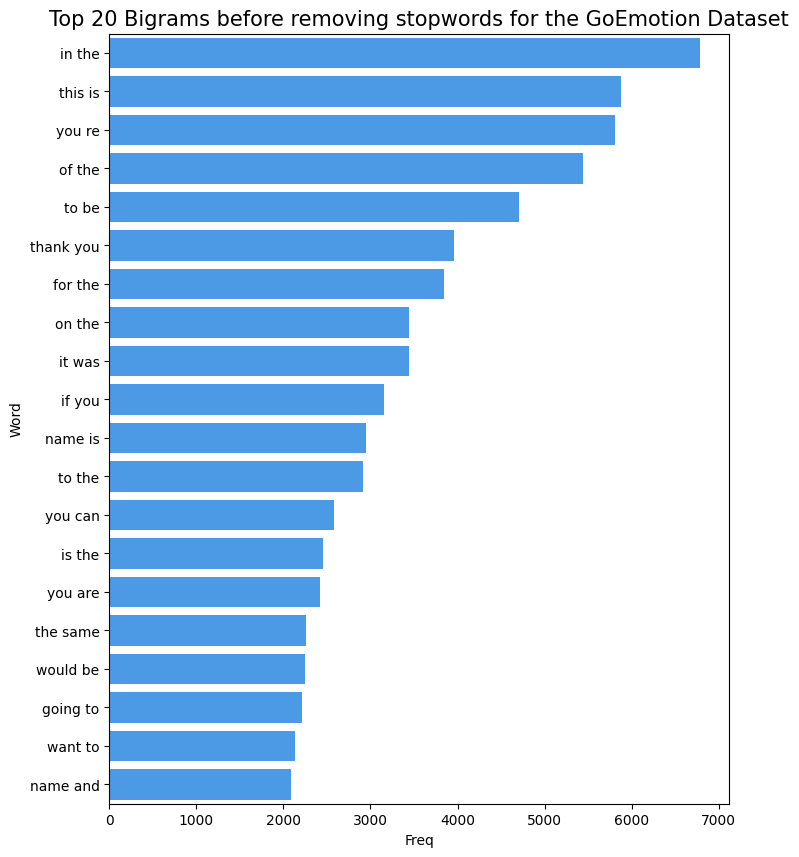

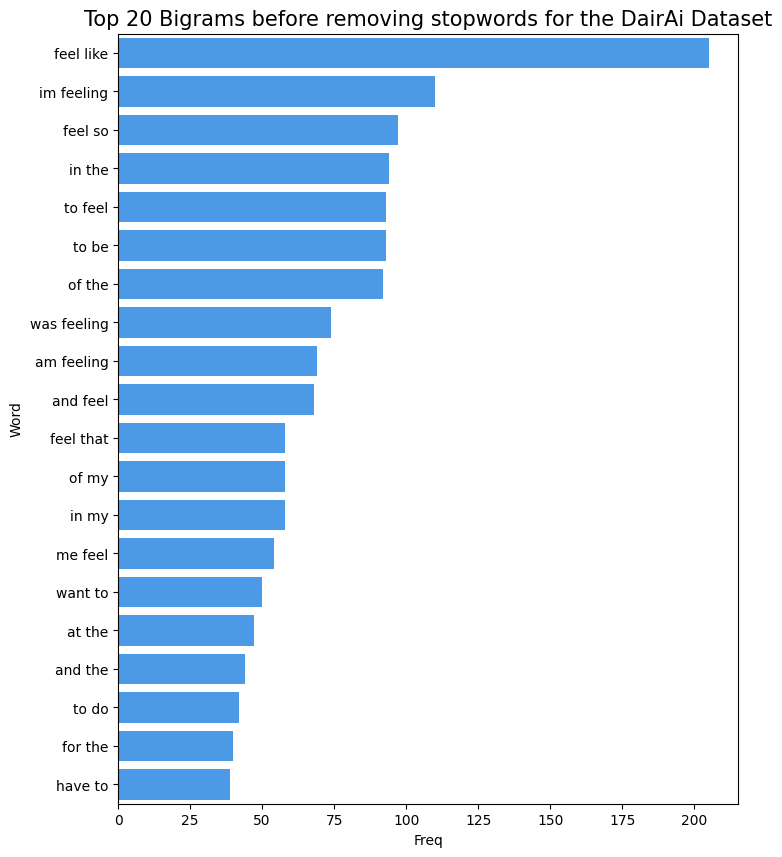

In [28]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bi_goEmotion)
plt.title('Top 20 Bigrams before removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bi_dairAI)
plt.title('Top 20 Bigrams before removing stopwords for the DairAi Dataset', size=15)
plt.show()

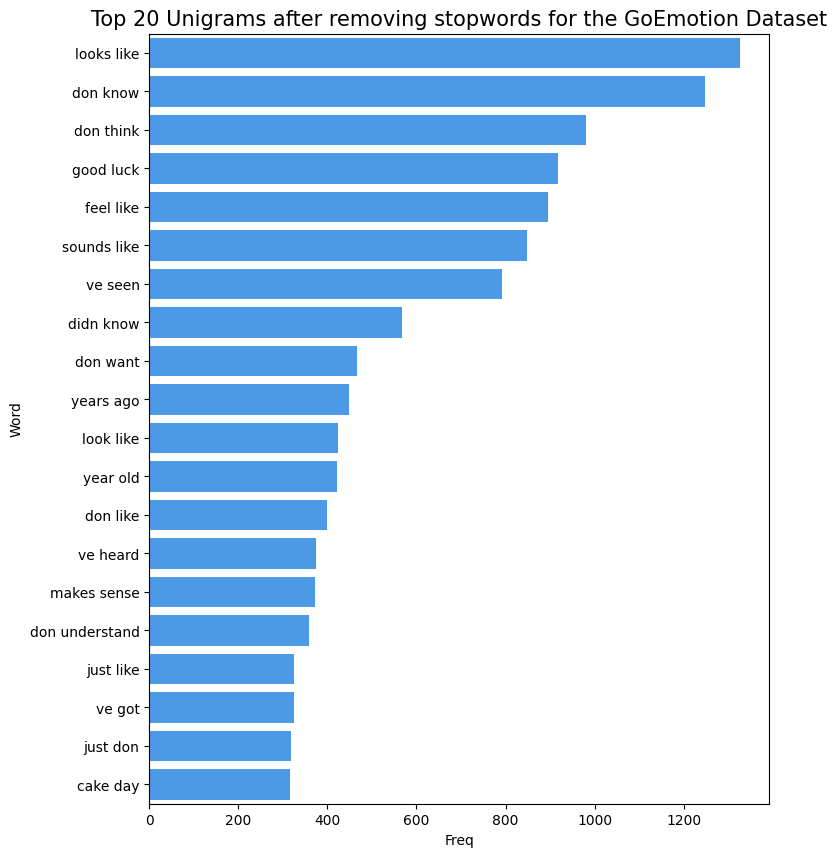

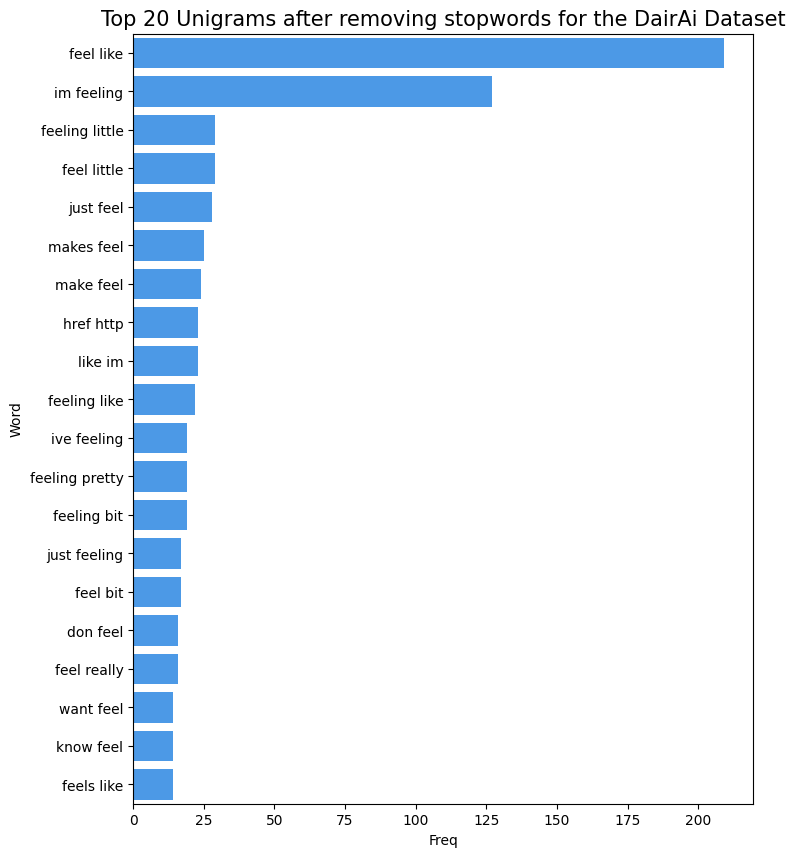

In [29]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bi_st_goEmotion)
plt.title('Top 20 Unigrams after removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bi_st_dairAI)
plt.title('Top 20 Unigrams after removing stopwords for the DairAi Dataset', size=15)
plt.show()

## Trigrams Distribution

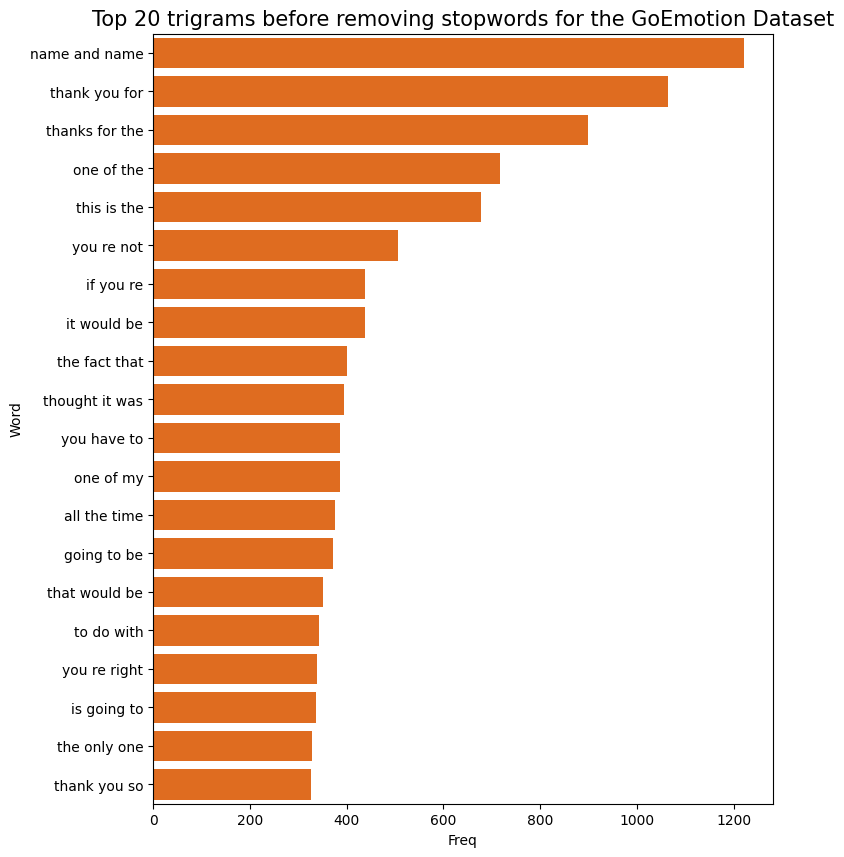

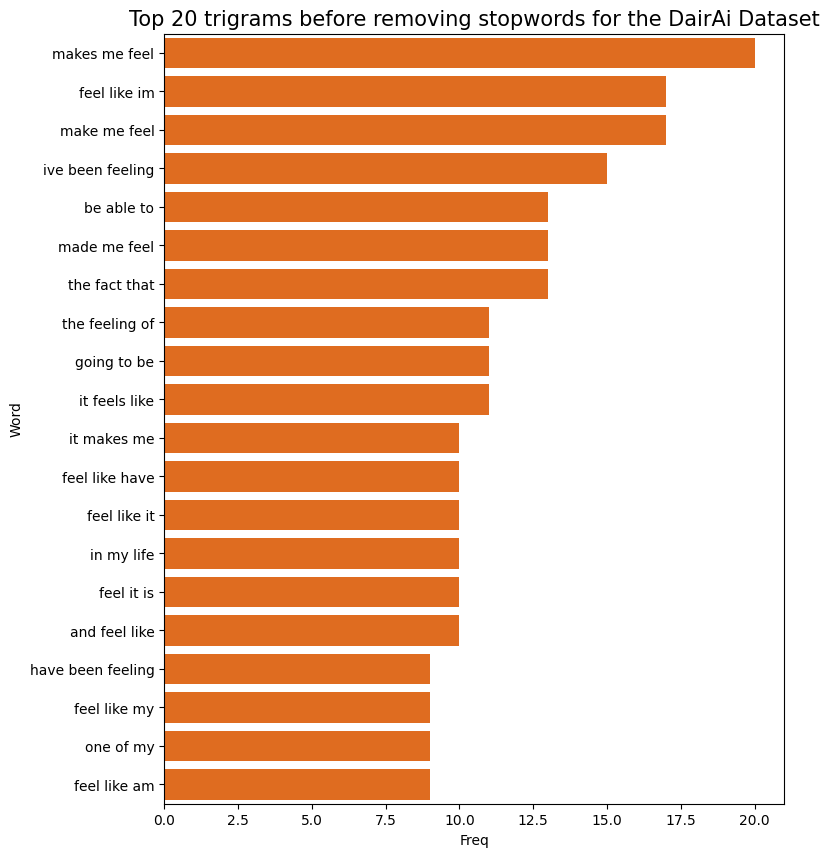

In [30]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[2], data=tri_goEmotion)
plt.title('Top 20 trigrams before removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[2], data=tri_dairAI)
plt.title('Top 20 trigrams before removing stopwords for the DairAi Dataset', size=15)
plt.show()

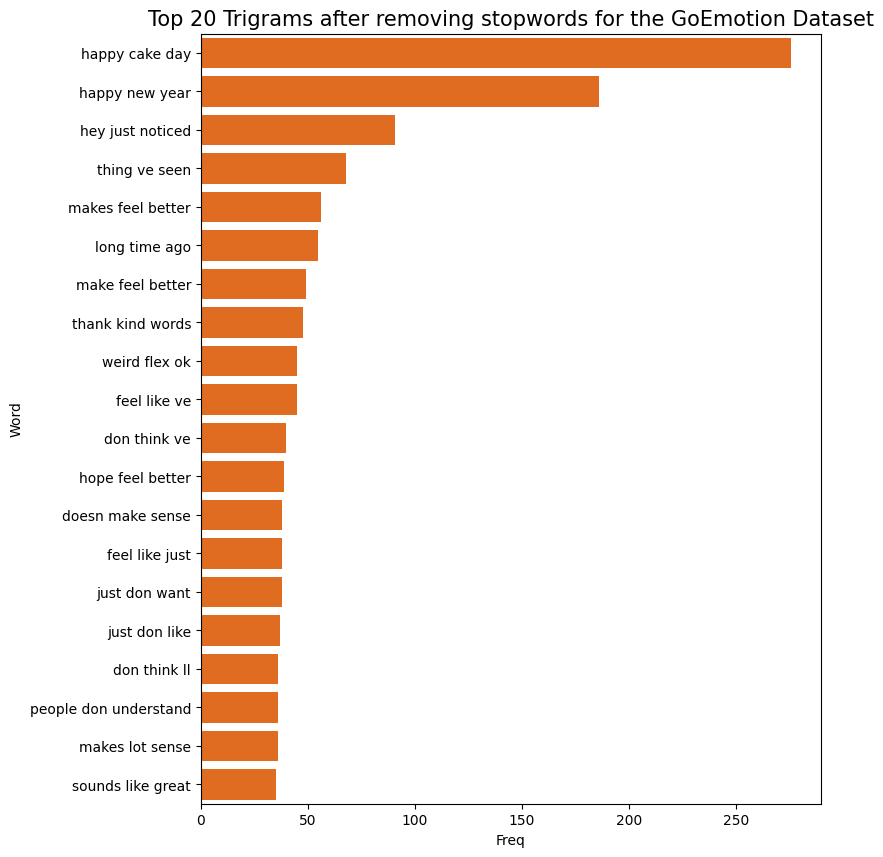

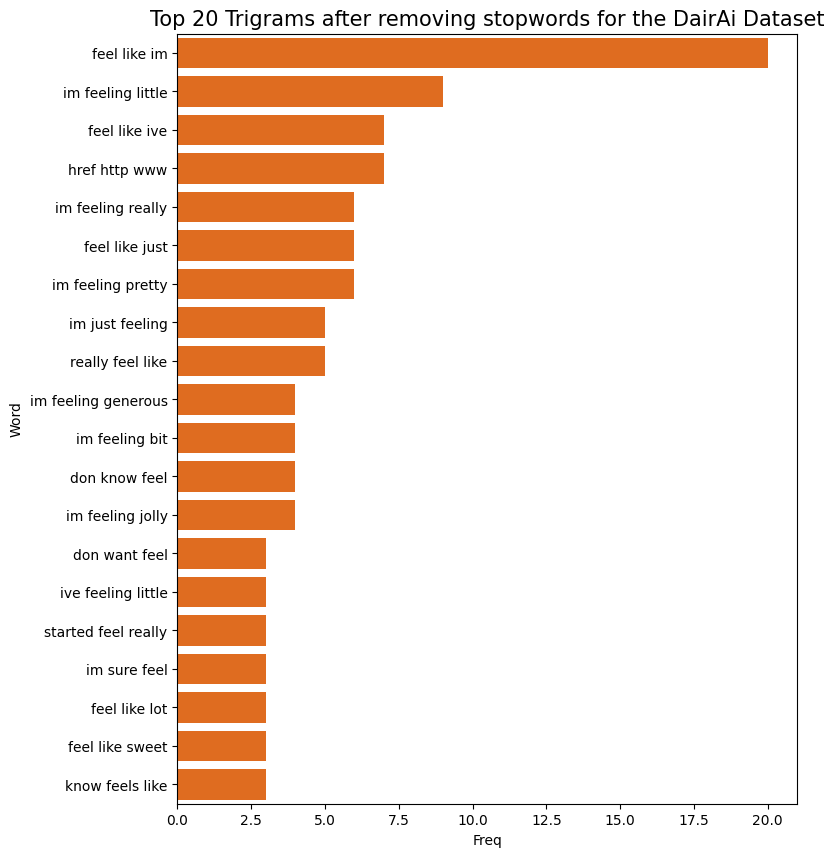

In [31]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[2], data=tri_st_goEmotion)
plt.title('Top 20 Trigrams after removing stopwords for the GoEmotion Dataset', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[2], data=tri_st_dairAI)
plt.title('Top 20 Trigrams after removing stopwords for the DairAi Dataset', size=15)
plt.show()

## Part-of-Speech Tagging (POS)

In [32]:
def getTopPos(df):
  blob = TextBlob(str(df['text']))
  pos_df = pd.DataFrame(blob.tags, columns=['word', 'pos'])
  #top_pos = pd.DataFrame(pos_df['pos'].value_counts(), columns=['pos', 'count'])
  top_pos = pos_df['pos'].value_counts()
  return top_pos

def POS(top_pos, title):
    plt.figure(figsize=(8, 10))
    sns.barplot(y=top_pos.index, x=top_pos.values, color=colors[0])
    plt.title(title, size=15)
    plt.show()

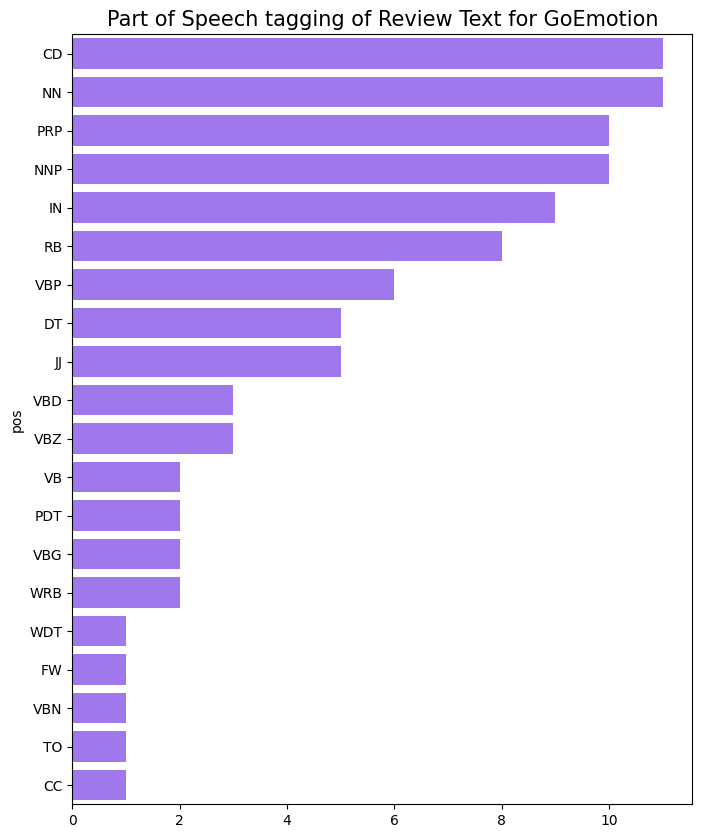

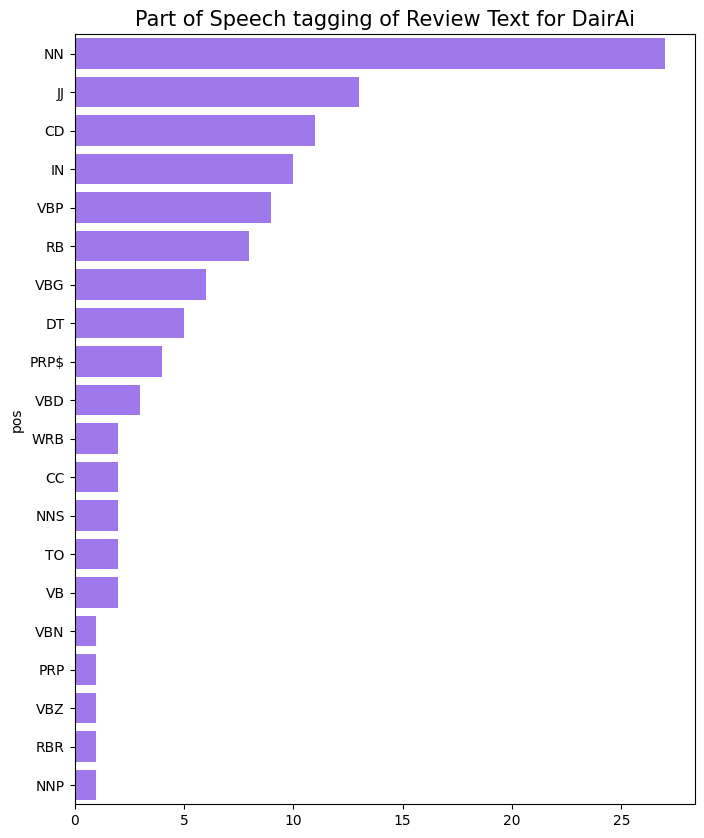

In [33]:
POS(getTopPos(df_GoEmotion), 'Part of Speech tagging of Review Text for GoEmotion')
POS(getTopPos(df_dairAI_test), 'Part of Speech tagging of Review Text for DairAi')

##Sentiment Polarity v/s Rater_id



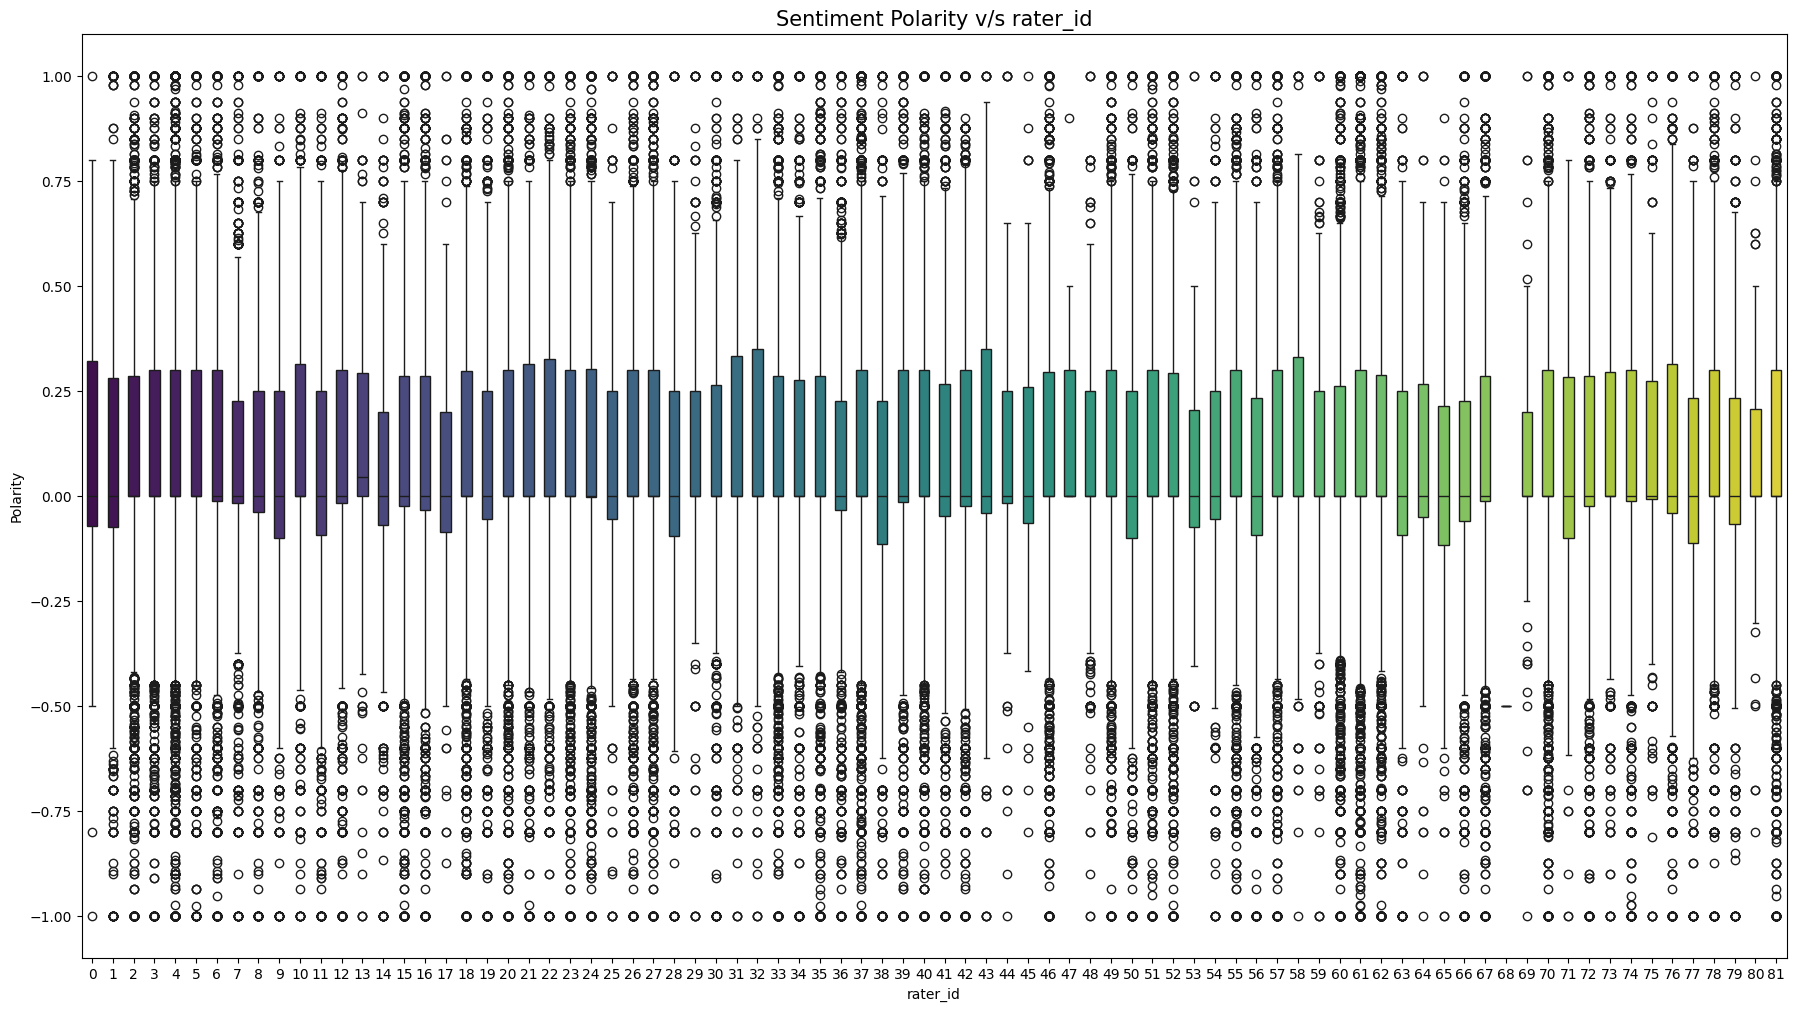

In [44]:
plt.figure(figsize=(22, 12))
sns.boxplot(x='rater_id', y='Polarity', width=0.5, palette='viridis', data=df_GoEmotion)
plt.title('Sentiment Polarity v/s rater_id', size=15)
plt.show()

## Distribution of Sentiment polarity of reviews based on Joy and Sadness Labels

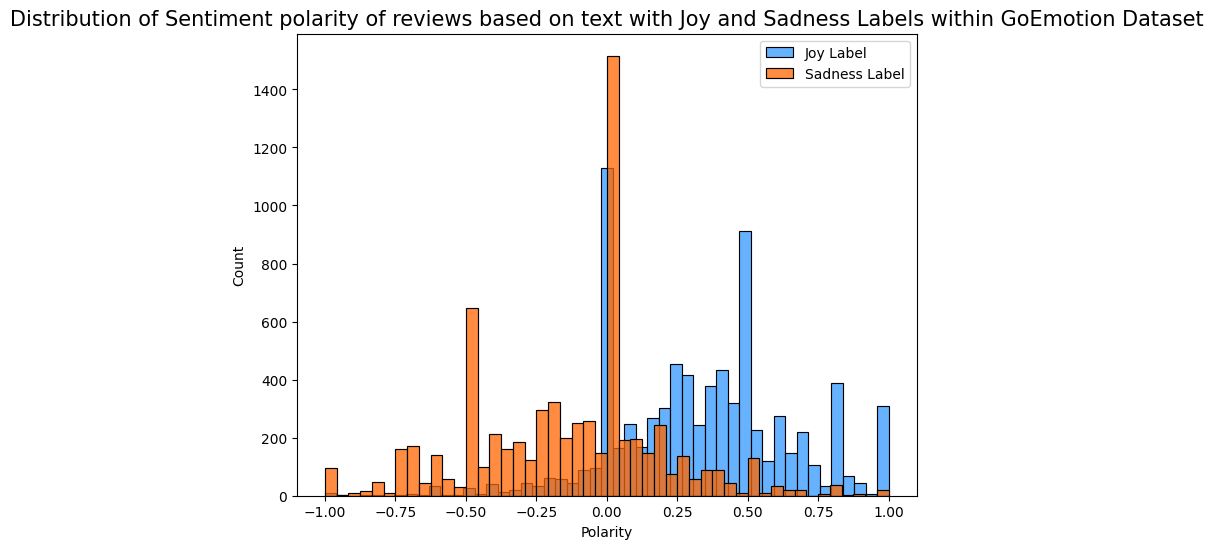

In [76]:
joyCount = df_GoEmotion.loc[df_GoEmotion['joy'] == 1, 'Polarity']
sadnessCount = df_GoEmotion.loc[df_GoEmotion['sadness'] == 1, 'Polarity']

plt.figure(figsize=(8, 6))
sns.histplot(x=joyCount, color=colors[1], label='Joy Label')
sns.histplot(x=sadnessCount, color=colors[2], label='Sadness Label')
plt.title('Distribution of Sentiment polarity of reviews based on text with Joy and Sadness Labels within GoEmotion Dataset', size=15)
plt.legend()
plt.show()

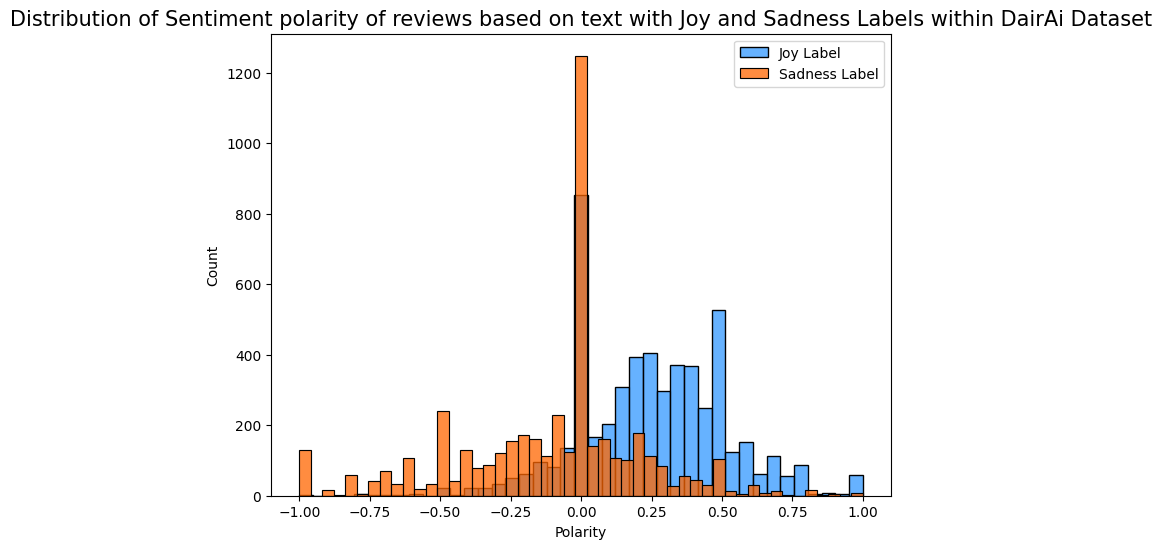

In [77]:
joyCount_Dair = df_dairAi_train.loc[df_dairAi_train['joy'] == 1, 'Polarity']
sadnessCount_dair = df_dairAi_train.loc[df_dairAi_train['sadness'] == 1, 'Polarity']

plt.figure(figsize=(8, 6))
sns.histplot(x=joyCount_Dair, color=colors[1], label='Joy Label')
sns.histplot(x=sadnessCount_dair, color=colors[2], label='Sadness Label')
plt.title('Distribution of Sentiment polarity of reviews based on text with Joy and Sadness Labels within DairAi Dataset', size=15)
plt.legend()
plt.show()

## Distribution of Word Count of reviews based on Joy and Sadness Labels

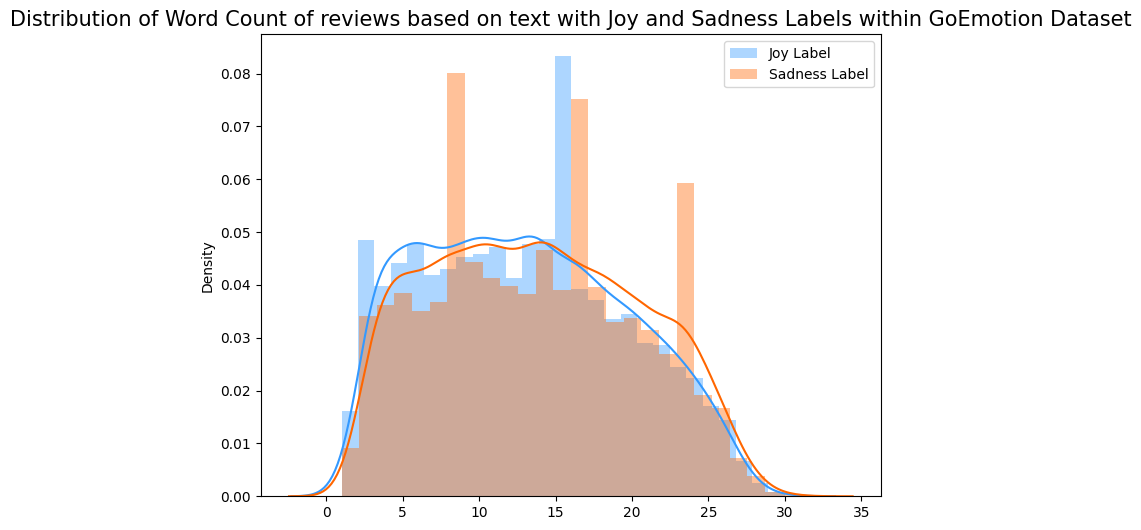

In [78]:
joyCount_word = df_GoEmotion.loc[df_GoEmotion['joy'] == 1, 'word_count']
sadnessCount_word = df_GoEmotion.loc[df_GoEmotion['sadness'] == 1, 'word_count']

plt.figure(figsize=(8, 6))
sns.distplot(x=joyCount_word, color=colors[1], label='Joy Label')
sns.distplot(x=sadnessCount_word, color=colors[2], label='Sadness Label')
plt.title('Distribution of Word Count of reviews based on text with Joy and Sadness Labels within GoEmotion Dataset', size=15)
plt.legend()
plt.show()

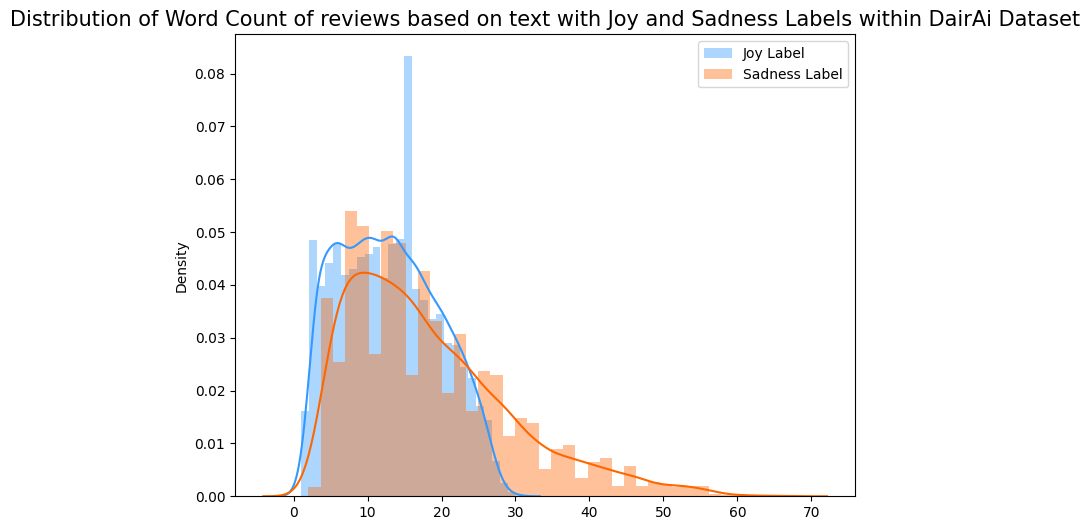

In [79]:
joyCount_dair_word = df_dairAi_train.loc[df_dairAi_train['joy'] == 1, 'word_count']
sadnessCount_dair_word = df_dairAi_train.loc[df_dairAi_train['sadness'] == 1, 'word_count']

plt.figure(figsize=(8, 6))
sns.distplot(x=joyCount_word, color=colors[1], label='Joy Label')
sns.distplot(x=sadnessCount_dair_word, color=colors[2], label='Sadness Label')
plt.title('Distribution of Word Count of reviews based on text with Joy and Sadness Labels within DairAi Dataset', size=15)
plt.legend()
plt.show()

## Distribution of Review length of reviews based on Joy and Sadness Labels

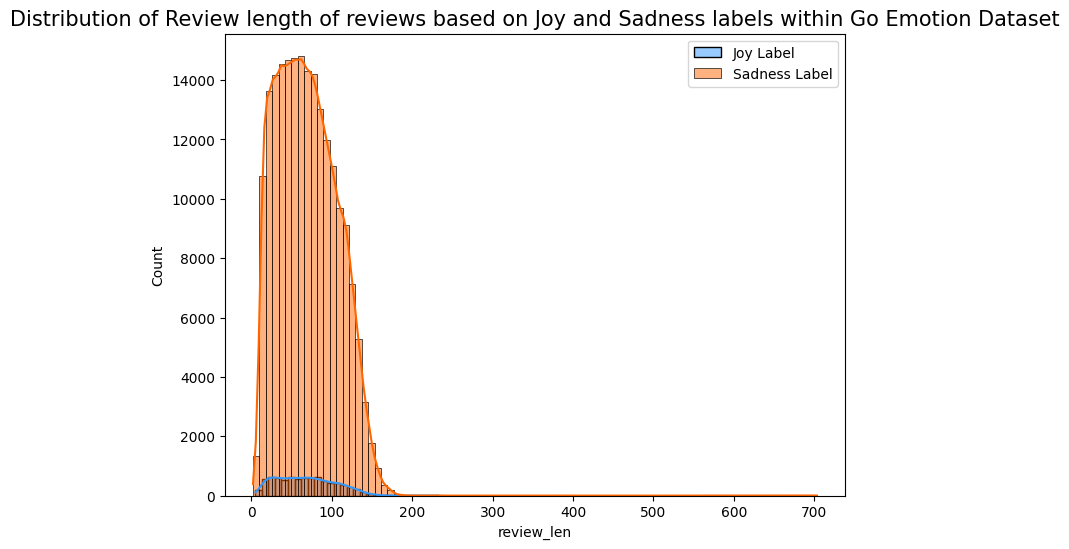

In [82]:
joyCount_Review = df_GoEmotion.loc[df_GoEmotion['joy'] == 1, 'review_len']
SadnessCount_Review = df_GoEmotion.loc[df_GoEmotion['sadness'] == 0, 'review_len']

plt.figure(figsize=(8, 6))
sns.histplot(x=joyCount_Review, color=colors[1], kde=True, label='Joy Label', binwidth=8)
sns.histplot(x=SadnessCount_Review, color=colors[2], kde=True, label='Sadness Label', binwidth=8)
plt.title('Distribution of Review length of reviews based on Joy and Sadness labels within Go Emotion Dataset', size=15)
plt.legend()
plt.show()

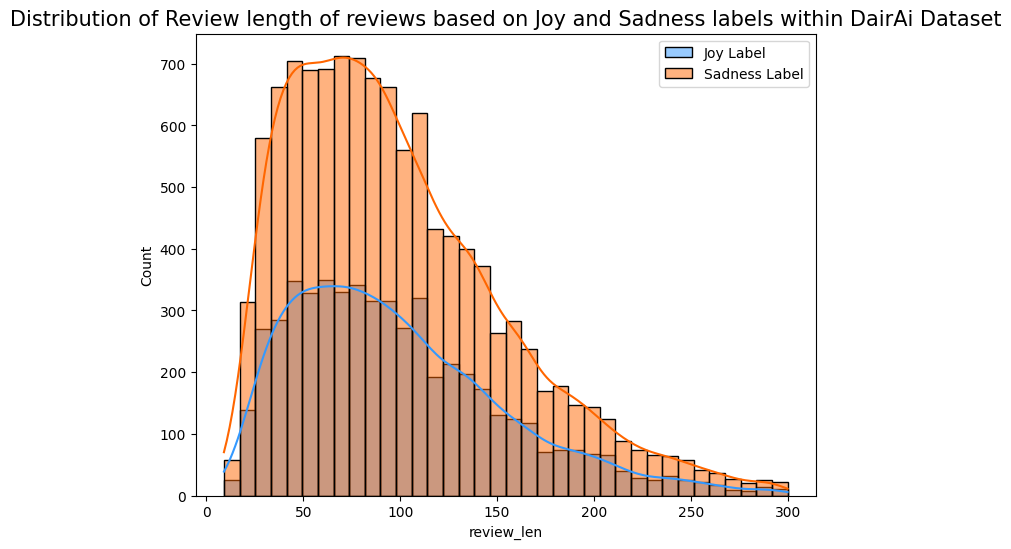

In [83]:
joyCount_Review_dair = df_dairAi_train.loc[df_dairAi_train['joy'] == 1, 'review_len']
SadnessCount_Review_dair = df_dairAi_train.loc[df_dairAi_train['sadness'] == 0, 'review_len']

plt.figure(figsize=(8, 6))
sns.histplot(x=joyCount_Review_dair, color=colors[1], kde=True, label='Joy Label', binwidth=8)
sns.histplot(x=SadnessCount_Review_dair, color=colors[2], kde=True, label='Sadness Label', binwidth=8)
plt.title('Distribution of Review length of reviews based on Joy and Sadness labels within DairAi Dataset', size=15)
plt.legend()
plt.show()

## 2D Density jointplot of review length and sentiment polarity

<Figure size 800x800 with 0 Axes>

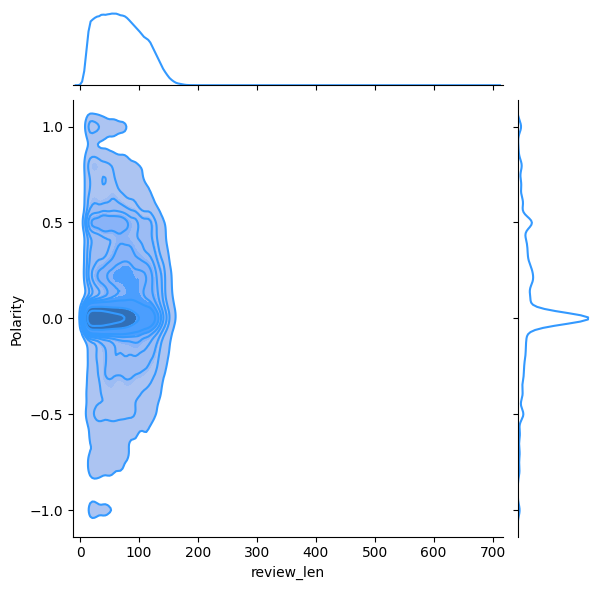

In [88]:
plt.figure(figsize=(8, 8))
g = sns.jointplot(x='review_len', y='Polarity', kind='kde', color=colors[1], data=df_GoEmotion)
g.plot_joint(sns.kdeplot, fill=True, color=colors[1], zorder=0, levels=6)

plt.show()

## 2D Density jointplot of word count and sentiment polarity

<Figure size 800x800 with 0 Axes>

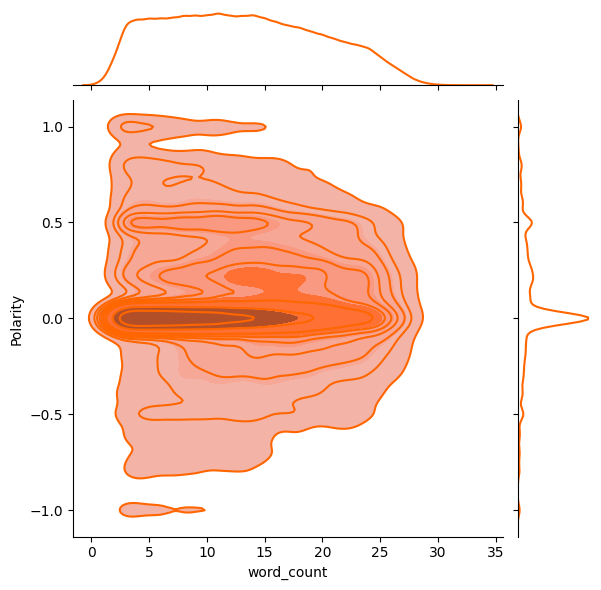

In [89]:
plt.figure(figsize=(8, 8))
g = sns.jointplot(x='word_count', y='Polarity', kind='kde', color=colors[2], data=df_GoEmotion)
g.plot_joint(sns.kdeplot, fill=True, color=colors[2], zorder=0, levels=6)

plt.show()